# Задание 1

Пользуясь алгоритмом Кросс-Энтропии обучить агента решать задачу Taxi-v3 из Gym. Исследовать гиперпараметры алгоритма и выбрать лучшие.

In [1]:
import pandas as pd
df = pd.read_csv("task1.csv")
df.head()

,epoch,reward,delivered,quantile,trajectories
0,0,-377.29,0,0.1,30
1,1,-378.37,0,0.1,30
2,2,-371.71,0,0.1,30
3,3,-376.30,0,0.1,30
4,4,-363.24,1,0.1,30


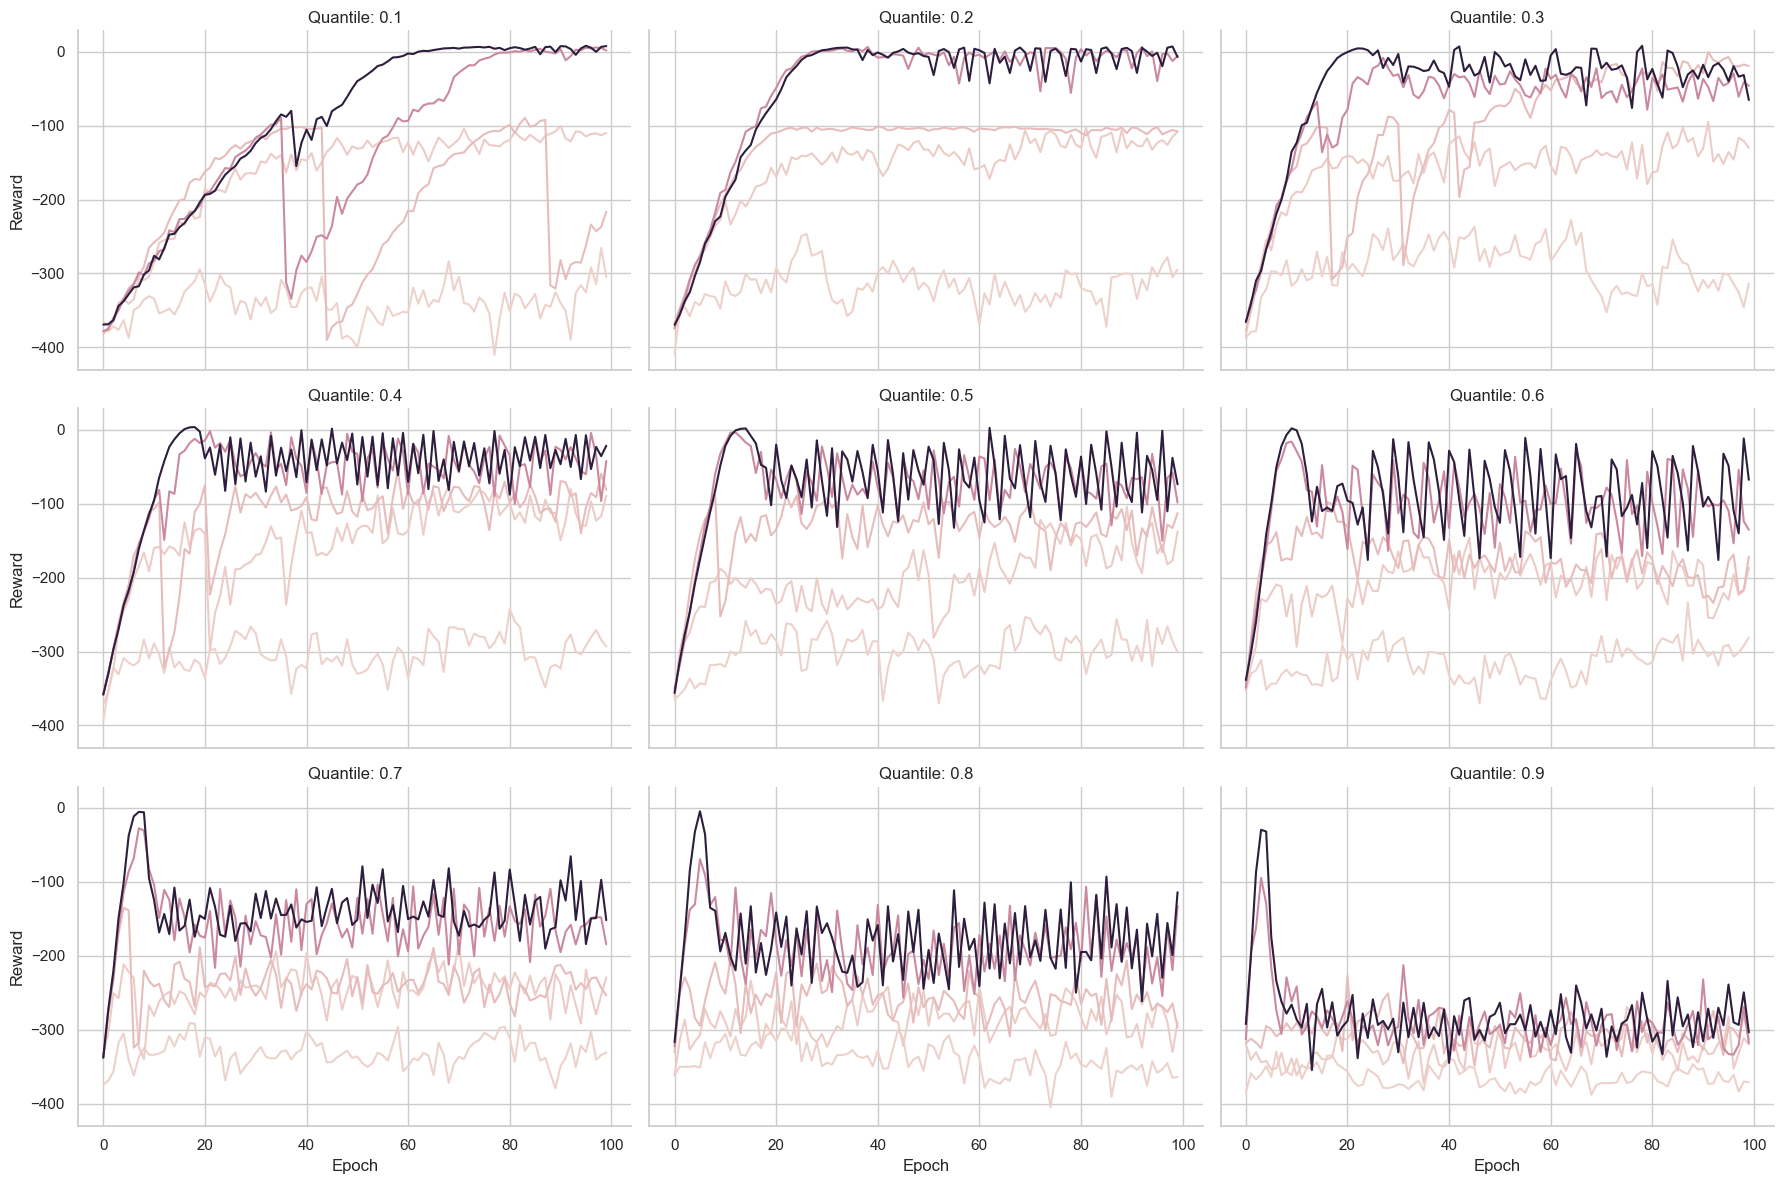

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

g = sns.FacetGrid(df, col='quantile', col_wrap=3, height=4, aspect=1.5)
g.map(sns.lineplot, 'epoch', 'reward', 'trajectories', markers=True)

g.set_axis_labels('Epoch', 'Reward')
g.set_titles(col_template="Quantile: {col_name}")

# Adjust layout
g.tight_layout()

# Show the plot
plt.show()

На графиках рассматриваются 2 гиперпараметра: квантиль и количество траекторий. Чем темнее график, тем больше траекторий, значения которые ипользовались: 30, 100, 300, 1000, 3000. Разные квантили представлены на разных графиках (от 0.1 до 0.9 включительно с шагом 0.1).

Рассмотрим количество траекторий. Интуиция подсказывает что, чем больше, тем лучше. Графику подтверждают эту гипотезу, бледные графики нигде не поднимаются близко к 0, два тёмных графика достигают значений в районе 0, то есть находят оптимальную стратегию. Существенных различий между 1000 и 3000 не видно, поэтому с целью экономии времени обучения 1000 будет рассматриваться как оптимальное значение количетсва траекторий для данной среды.

Ситуация с квантилями интереснее, видно что везде алгоритм быстро приближается к 0, а потом падает ниже. Чем выше квантиль, тем быстрее обучается алгоритм, но тем ниже падает после этого. Оптимальным значением квантиля для этой среды выглядит 0.2.

Падение графиков после достижения 0 обусловлено спецификой алгоритма. Чем агрессивнее вы выкидываем траектории, тем больше вероятность, что какие то состояния ни разу не будут посещены. Если состояние не представлено в траекториях, то агент действует в нём случайно. При низких квантилях мы оставляем достаточно траекторий, чтоб гарантировать высокую вероятность попадания всех состояний.

**Результат**:
* Количество траекторий: 1000 (достаточно, но чем больше, тем лучше)
* Квинтиль: 0.2

# Задание 2

Реализовать алгоритм Кросс-Энтропии с двумя типами сглаживания,  указанными в лекции 1. При выбранных в пункте 1 гиперпараметров сравнить их результаты с результатами алгоритма без сглаживания.

In [16]:
df2 = pd.read_csv("task2.csv")
df2.head()

,epoch,reward,delivered,quantile,trajectories,smoothing,alpha
0,0,-369.91,0,0.2,1000,Laplace,0.1
1,1,-357.49,2,0.2,1000,Laplace,0.1
2,2,-346.10,2,0.2,1000,Laplace,0.1
3,3,-321.67,5,0.2,1000,Laplace,0.1
4,4,-306.43,2,0.2,1000,Laplace,0.1


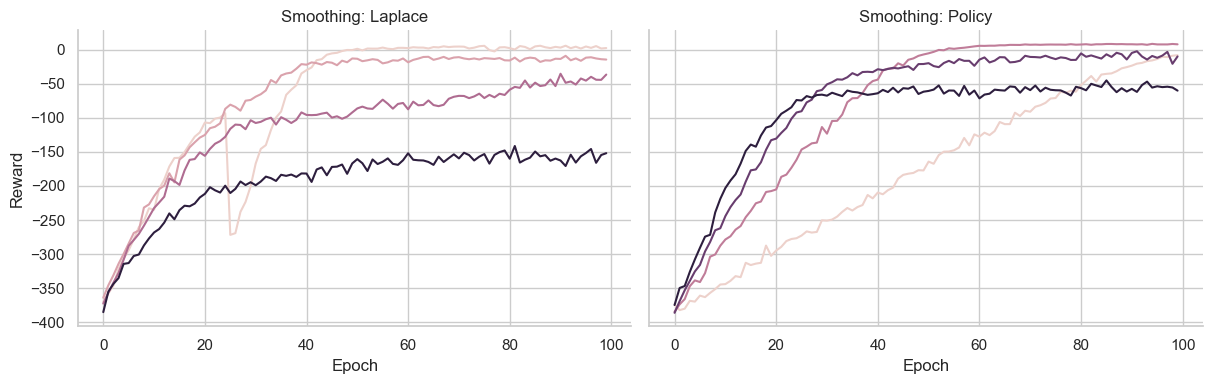

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

g = sns.FacetGrid(df2, col='smoothing', col_wrap=3, height=4, aspect=1.5)
g.map(sns.lineplot, 'epoch', 'reward', 'alpha', markers=True)

g.set_axis_labels('Epoch', 'Reward')
g.set_titles(col_template="Smoothing: {col_name}")

# Adjust layout
g.tight_layout()

# Show the plot
plt.show()

Для начала проанализируем гипетпараметры сглаживаний, чтоб подобрать оптимальные. Для сглаживания Лапласа возьмём: [0.1, 0.5, 1, 2]. На графике видно, что значение 0.1 даёт наилучшие результаты, хотя и имеет резкое падение в процессе обучения.

Для сглаживания политики рассматрим значения: [0.25, 0.5, 0.75, 0.9]. Видно, что высокие значения растут быстрее, но так и не достигают стабильных результатов, при низком значении 0.25 график растёт почти линейно, наверняка сойдётся к хорошей политике, но обучение довольно долгое. Значение 0.5 выглядит оптимальным.

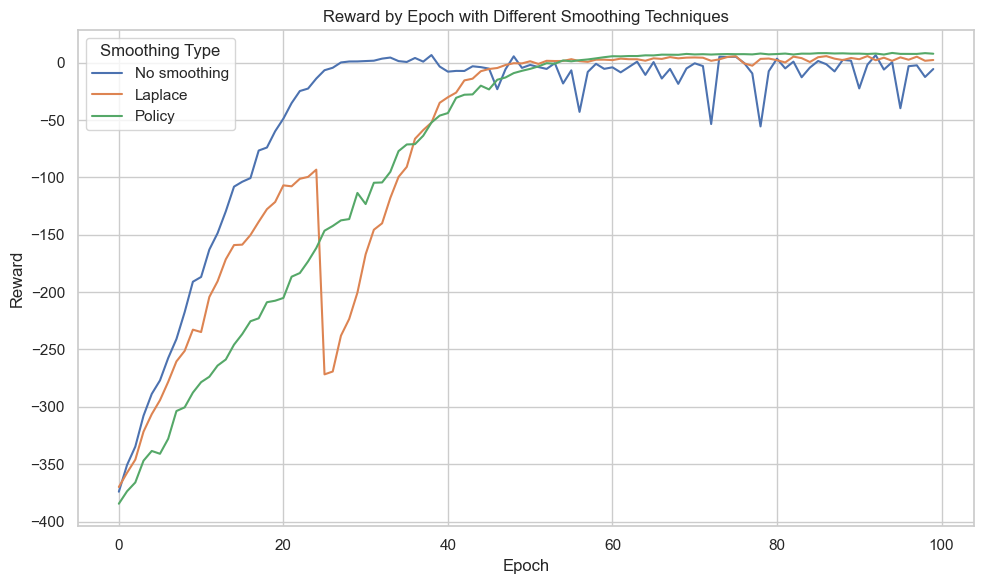

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

df["smoothing"] = "No smoothing"

df_combined = pd.concat([
    df[(df["quantile"] == 0.2) & (df["trajectories"] == 1000)][["epoch", "reward", "smoothing"]],
    df2[(df2["smoothing"] == "Laplace") & (df2["alpha"] == 0.1)][["epoch", "reward", "smoothing"]],
    df2[(df2["smoothing"] == "Policy") & (df2["alpha"] == 0.5)][["epoch", "reward", "smoothing"]]])

plt.figure(figsize=(10, 6))

sns.lineplot(data=df_combined, x='epoch', y='reward', hue='smoothing', markers=True)

# Set axis labels and title
plt.xlabel('Epoch')
plt.ylabel('Reward')
plt.title('Reward by Epoch with Different Smoothing Techniques')

# Show legend
plt.legend(title='Smoothing Type')

# Show the plot
plt.tight_layout()
plt.show()

На графике видно, что без сглаживания алгоритм обучается намного быстрее, чем со сглаживанием, зато никогда не достигает стабильного состояния и часто средняя награда падает до -50. Два других сглаживания ведут себя похожим образом, policy smoothing показывает чуть лучшие результат.

# Задание 3

Реализовать модификацию алгоритм Кросс-Энтропии для стохастических сред, указанную в лекции 1. Сравнить ее результат с алгоритмами из пунктов 1 и 2.

In [34]:
df3 = pd.read_csv("task3.csv")
df3.head()

,epoch,reward,delivered,quantile,trajectories,type,sample_count
0,0,-457.70,1,0.2,1000,Averaging,5
1,1,-514.59,1,0.2,1000,Averaging,5
2,2,-496.99,0,0.2,1000,Averaging,5
3,3,-486.73,0,0.2,1000,Averaging,5
4,4,-472.33,0,0.2,1000,Averaging,5


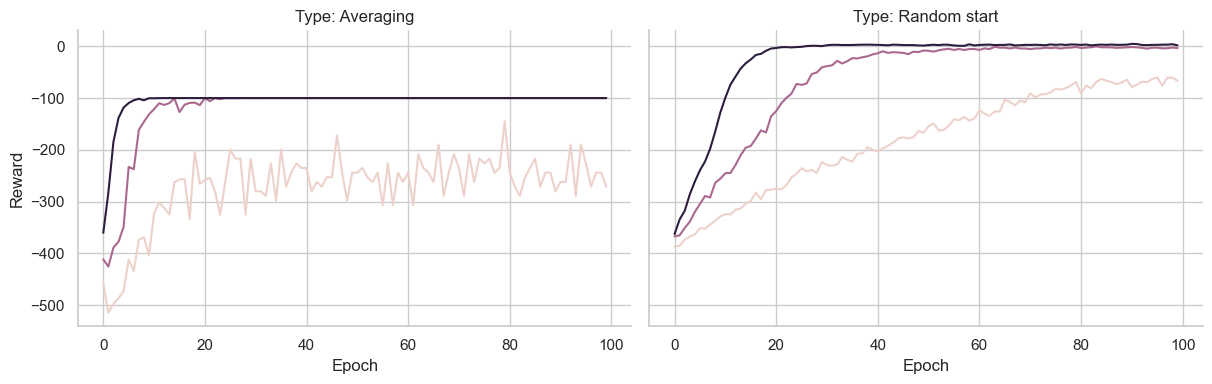

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

g = sns.FacetGrid(df3, col='type', col_wrap=3, height=4, aspect=1.5)
g.map(sns.lineplot, 'epoch', 'reward', 'quantile', markers=True)

g.set_axis_labels('Epoch', 'Reward')
g.set_titles(col_template="Type: {col_name}")

# Adjust layout
g.tight_layout()

# Show the plot
plt.show()

В задании 1 оптимальный квантиль был 0.2 по причине того, что некоторые состояния не попадали в элитные сессии по случайности. Усреднение сессий призвано бороться с этой проблемой, поэтому 0.2 может быть неоптимальным значением вместе с усреднением. В данном эксперименте использовались 3 значения: [0.2, 0.5, 0.8]. Как показывает эксперимент, оптимальным значением квантиля с усреднением будет 0.8. Усреднение проводилось среди 5 траекторий. Эксперименты с усреднением сложно сравнивать с предыдущими, так как за счёт усреднения, суммарное количество траекторий увеличилось в 5 раз, то есть нельзя сказать, что алгоритмы были в равных условиях. Сократить количество траекторий в 5 раз тоже нельзя, так как многие траектории из третьего задания похожи друг на друга и имеют одинаковую (усреднённую) награду.

На первом графике используется усреднение предложенное на лекциях: из стохастической политики сэмплируется N детерминированных политик и симуляция среды проходит K раз для каждой из них, потом награда усредняется для каждой детерминированной политики из одного семейства. Как видно на первом графике, политики сходятся к значению -100, очевидно, что это -1 за каждый шаг при ограничении в 100 шагов для симуляции. Поскольку агент получает усреднённую награду, агент почти сразу начинает избегать рискованных действий (взять/высадить пассажира), за которые с большой вероятностью получит -10, и только в редком случае +20.

На втором графике приведёт похожий подход из дополнительных материалов курса: Practical_RL от Яндекса. В нём борьба с неудачными состояними не попавшими в элитные сессии решается так: первое действие всегда случайное, после него симулируется N траекторий и награда по ним усредняется. Таким образом мы увеличиваем присутствие всех пар состояние/действие в траекториях и сглаживаем их влияние с помощью нескольких симуляций. Как видно такой подход даёт наилучшие результаты.